# Introduction
In my [previous work](https://www.kaggle.com/code/lazygene/exploring-psychiatric-disorders-eeg-dataset) I explored the dataset and performed multi-class classification. Here, I concentrate on binary classification disorder vs. healthy controls and report feature importance for the best performing models during 10-fold cross-validation.



In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install catboost

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.5/98.5 MB 9.7 MB/s eta 0:00:00


# Import libraries

In [ ]:
import os
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib.patheffects as PathEffects
import pickle
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OrdinalEncoder, StandardScaler
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.metrics import classification_report
from catboost import CatBoostClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from copy import deepcopy
from tqdm import tqdm

# Read Data

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/AccioBeer/EEG.machinelearing_data_BRMH.csv')
df.head()

,no.,sex,age,eeg.date,education,IQ,main.disorder,specific.disorder,AB.A.delta.a.FP1,AB.A.delta.b.FP2,...,COH.F.gamma.o.Pz.p.P4,COH.F.gamma.o.Pz.q.T6,COH.F.gamma.o.Pz.r.O1,COH.F.gamma.o.Pz.s.O2,COH.F.gamma.p.P4.q.T6,COH.F.gamma.p.P4.r.O1,COH.F.gamma.p.P4.s.O2,COH.F.gamma.q.T6.r.O1,COH.F.gamma.q.T6.s.O2,COH.F.gamma.r.O1.s.O2
0,1,M,57.0,2012.8.30,NaN,NaN,Addictive disorder,Alcohol use disorder,35.998557,21.717375,...,55.989192,16.739679,23.452271,45.678820,30.167520,16.918761,48.850427,9.422630,34.507082,28.613029
1,2,M,37.0,2012.9.6,6.0,120.0,Addictive disorder,Alcohol use disorder,13.425118,11.002916,...,45.595619,17.510824,26.777368,28.201062,57.108861,32.375401,60.351749,13.900981,57.831848,43.463261
2,3,M,32.0,2012.9.10,16.0,113.0,Addictive disorder,Alcohol use disorder,29.941780,27.544684,...,99.475453,70.654171,39.131547,69.920996,71.063644,38.534505,69.908764,27.180532,64.803155,31.485799
3,4,M,35.0,2012.10.8,18.0,126.0,Addictive disorder,Alcohol use disorder,21.496226,21.846832,...,59.986561,63.822201,36.478254,47.117006,84.658376,24.724096,50.299349,35.319695,79.822944,41.141873
4,5,M,36.0,2012.10.18,16.0,112.0,Addictive disorder,Alcohol use disorder,37.775667,33.607679,...,61.462720,59.166097,51.465531,58.635415,80.685608,62.138436,75.888749,61.003944,87.455509,70.531662


In [ ]:
df["main.disorder"].unique()

array(['Addictive disorder', 'Trauma and stress related disorder',
       'Mood disorder', 'Healthy control',
       'Obsessive compulsive disorder', 'Schizophrenia',
       'Anxiety disorder'], dtype=object)

Let's rename some of the columns:
- XX.X.band.x.channel to band.channel
- COH.X.band.x.channel1.x.channel2 to COH.band.channel1.channel2

In [ ]:
new_df1 = df[df['main.disorder'] == 'Anxiety disorder']
new_df2 = df[df['main.disorder'] == 'Healthy control']
new_df3 = df[ df['main.disorder'] == 'Mood disorder']

concatenated_df = pd.concat([new_df1, new_df2, new_df3], ignore_index=True)
concatenated_df.shape

(468, 1149)

Fix typo in specific.disorder:

Obsessive compulsi**t**ve disorder to Obsessive compulsive disorder

In [ ]:
df.shape

(945, 1149)

In [ ]:
# function to rename
def reformat_name(name):
    '''
    reformat from XX.X.band.x.channel to band.channel or
    COH.X.band.x.channel1.x.channel2 to COH.band.channel1.channel2
    '''
    splitted = name.split(sep='.')
    if len(splitted) < 5:
        return name
    if splitted[0] != 'COH':
        result = f'{splitted[2]}.{splitted[4]}'
    else:
        result = f'{splitted[0]}.{splitted[2]}.{splitted[4]}.{splitted[6]}'
    return result
# rename columns
df.rename(reformat_name, axis=1, inplace=True)
df

,no.,sex,age,eeg.date,education,IQ,main.disorder,specific.disorder,delta.FP1,delta.FP2,...,COH.gamma.Pz.P4,COH.gamma.Pz.T6,COH.gamma.Pz.O1,COH.gamma.Pz.O2,COH.gamma.P4.T6,COH.gamma.P4.O1,COH.gamma.P4.O2,COH.gamma.T6.O1,COH.gamma.T6.O2,COH.gamma.O1.O2
0,1,M,57.0,2012.8.30,NaN,NaN,Addictive disorder,Alcohol use disorder,35.998557,21.717375,...,55.989192,16.739679,23.452271,45.678820,30.167520,16.918761,48.850427,9.422630,34.507082,28.613029
1,2,M,37.0,2012.9.6,6.0,120.0,Addictive disorder,Alcohol use disorder,13.425118,11.002916,...,45.595619,17.510824,26.777368,28.201062,57.108861,32.375401,60.351749,13.900981,57.831848,43.463261
2,3,M,32.0,2012.9.10,16.0,113.0,Addictive disorder,Alcohol use disorder,29.941780,27.544684,...,99.475453,70.654171,39.131547,69.920996,71.063644,38.534505,69.908764,27.180532,64.803155,31.485799
3,4,M,35.0,2012.10.8,18.0,126.0,Addictive disorder,Alcohol use disorder,21.496226,21.846832,...,59.986561,63.822201,36.478254,47.117006,84.658376,24.724096,50.299349,35.319695,79.822944,41.141873
4,5,M,36.0,2012.10.18,16.0,112.0,Addictive disorder,Alcohol use disorder,37.775667,33.607679,...,61.462720,59.166097,51.465531,58.635415,80.685608,62.138436,75.888749,61.003944,87.455509,70.531662
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
940,941,M,22.0,2014.8.28,13.0,116.0,Healthy control,Healthy control,41.851823,36.771496,...,82.905657,34.850706,63.970519,63.982003,51.244725,62.203684,62.062237,31.013031,31.183413,98.325230
941,942,M,26.0,2014.9.19,13.0,118.0,Healthy control,Healthy control,18.986856,19.401387,...,65.917918,66.700117,44.756285,49.787513,98.905995,54.021304,93.902401,52.740396,92.807331,56.320868
942,943,M,26.0,2014.9.27,16.0,113.0,Healthy control,Healthy control,28.781317,32.369230,...,61.040959,27.632209,45.552852,33.638817,46.690983,19.382928,41.050717,7.045821,41.962451,19.092111
943,944,M,24.0,2014.9.20,13.0,107.0,Healthy control,Healthy control,19.929100,25.196375,...,99.113664,48.328934,41.248470,28.192238,48.665743,42.007147,28.735945,27.176500,27.529522,20.028446


In [ ]:
typo_ind = df[df['specific.disorder'] == 'Obsessive compulsitve disorder'].index
df.loc[typo_ind, 'specific.disorder'] = 'Obsessive compulsive disorder'

# EDA
You can find it in [this notebook](https://www.kaggle.com/code/lazygene/exploring-psychiatric-disorders-eeg-dataset).

# Missing data

Extract separation column between PSD and FC data.

In [ ]:
missing = df.isna().sum()
sep_col = missing[missing == df.shape[0]].index[0]
sep_col

'Unnamed: 122'

In [ ]:
missing

no.                 0
sex                 0
age                 0
eeg.date            0
education          15
                   ..
COH.gamma.P4.O1     0
COH.gamma.P4.O2     0
COH.gamma.T6.O1     0
COH.gamma.T6.O2     0
COH.gamma.O1.O2     0
Length: 1149, dtype: int64

In [ ]:
missing[missing > 0]

education        15
IQ               13
Unnamed: 122    945
dtype: int64

In [ ]:
educ_na = df[df['education'].isna()]
iq_na = df[df['IQ'].isna()]
educ_iq_na = pd.concat([educ_na, iq_na]).drop_duplicates()
educ_iq_na

,no.,sex,age,eeg.date,education,IQ,main.disorder,specific.disorder,delta.FP1,delta.FP2,...,COH.gamma.Pz.P4,COH.gamma.Pz.T6,COH.gamma.Pz.O1,COH.gamma.Pz.O2,COH.gamma.P4.T6,COH.gamma.P4.O1,COH.gamma.P4.O2,COH.gamma.T6.O1,COH.gamma.T6.O2,COH.gamma.O1.O2
0,1,M,57.00,2012.8.30,NaN,NaN,Addictive disorder,Alcohol use disorder,35.998557,21.717375,...,55.989192,16.739679,23.452271,45.678820,30.167520,16.918761,48.850427,9.422630,34.507082,28.613029
17,18,M,30.00,2013.9.27,NaN,86.0,Addictive disorder,Alcohol use disorder,12.443237,12.503703,...,85.080600,53.533875,62.817411,68.040950,71.834549,48.779049,80.516443,22.049743,76.277261,45.629506
21,22,M,20.00,2014.10.23,NaN,116.0,Addictive disorder,Alcohol use disorder,28.287190,22.412264,...,33.065475,24.351780,18.764173,32.610337,38.451805,20.933501,48.626712,16.258394,40.471735,24.175359
155,156,M,18.00,2013.12.7,NaN,103.0,Addictive disorder,Behavioral addiction disorder,16.548803,19.042179,...,93.825121,79.091595,83.132315,88.900783,87.508591,76.257681,89.811513,62.739950,84.729816,86.322844
173,174,M,23.00,2015.11.14,NaN,113.0,Healthy control,Healthy control,19.050158,23.277470,...,68.005720,54.685472,70.694110,62.676608,67.705314,46.667642,66.673782,29.689482,74.787580,51.039538
269,270,M,25.00,2015.9.23,NaN,85.0,Obsessive compulsive disorder,Obsessive compulsive disorder,6.186264,7.112847,...,72.743284,63.723838,61.257858,67.473157,77.664778,57.967084,73.898719,59.775191,81.941728,72.195171
270,271,M,34.00,2015.9.21,NaN,120.0,Obsessive compulsive disorder,Obsessive compulsive disorder,12.784872,15.922964,...,72.409132,49.265064,41.222401,68.010480,72.429188,26.188907,68.653874,18.072318,63.285321,41.822238
279,280,M,35.00,2016.6.2,NaN,NaN,Obsessive compulsive disorder,Obsessive compulsive disorder,21.524573,22.227615,...,90.934877,93.568209,94.185299,92.271775,96.445879,91.470862,96.851513,92.296182,96.209585,96.660561
280,281,M,37.00,2016.6.27,NaN,110.0,Obsessive compulsive disorder,Obsessive compulsive disorder,11.971083,11.374465,...,91.150863,78.359575,64.861521,74.389105,89.863923,50.322649,75.469583,49.440177,84.022887,69.921675
281,282,M,22.00,2016.6.30,NaN,107.0,Obsessive compulsive disorder,Obsessive compulsive disorder,12.516343,10.136242,...,96.419647,77.360976,95.156801,96.105427,87.746498,94.760227,97.579921,81.495805,86.770154,98.121870


In [ ]:
drop_md = educ_iq_na['main.disorder'].value_counts().sort_index()
all_md = df['main.disorder'].value_counts().sort_index()[drop_md.index]
pd.concat([all_md, drop_md/all_md * 100], axis=1).set_axis(['all_data', 'na_percentage'], axis=1).sort_values('na_percentage', ascending=False)

,all_data,na_percentage
Obsessive compulsive disorder,46,13.043478
Addictive disorder,186,4.301075
Trauma and stress related disorder,128,3.906250
Healthy control,95,2.105263
Mood disorder,266,1.503759
Anxiety disorder,107,0.934579


We will loose too much data (13%) on patients with obsessive compulsive disorder, which is one of the smallest groups already. So we should consider filling missing data.  
Our options to fill them are:
- special value
- mean/median value
- imputation

We will fill missing data with **median values**.

In [ ]:
display(df[['education', 'IQ']].agg(['mean', 'median']))
imputer = SimpleImputer(strategy='median')

,education,IQ
mean,13.43871,101.580472
median,13.00000,102.000000


# Pre-processing
To prepare data for classification we need:

1. Drop separation column, id colums (no. and eeg.date)
1. Encode target (main.disorder and specific.disorder) and categorical (sex) varables
1. Drop target variables from features
1. Fill missing data in education and IQ columns
1. Apply log transformation to Age, PSD and FC features
1. Separate features and targets into separate subset for binary classification (disorder vs. healthy control)
1. Scale features

In [ ]:
# drop columns we don't need
X = df.drop([sep_col, 'no.', 'eeg.date'], axis=1).copy(deep=True)
# target and categorical columns
target_col = ['main.disorder', 'specific.disorder']
cat_col = ['sex', 'main.disorder','specific.disorder']
# unique disorders
md_unique = df['main.disorder'].unique()
sd_unique = df['specific.disorder'].unique()
# make sure that healthy control is encoded as zero
hc = 'Healthy control'
# lists of disorders without healthy control
md = md_unique[md_unique != hc]
sd = sd_unique[sd_unique != hc]
md_ord = np.insert(md, 0, hc)
sd_ord = np.insert(sd, 0, hc)
sex_ord = df['sex'].unique()
# encoder for targets and sex
enc = OrdinalEncoder(categories=[sex_ord, md_ord, sd_ord])
X[cat_col] = enc.fit_transform(X[cat_col])
# save targets
md_target = X['main.disorder']
sd_target = X['specific.disorder']
# drop targets
X.drop(target_col, axis=1, inplace=True)
# fill missing data
mv_cols = ['education', 'IQ']
X[mv_cols] = imputer.fit_transform(X[mv_cols])
# numerical columns for log-transformation
logtrans_cols = X.drop(['sex', 'education', 'IQ'], axis=1).columns
X[logtrans_cols] = np.log(X[logtrans_cols])

In [ ]:
sd_ord

array(['Healthy control', 'Alcohol use disorder', 'Acute stress disorder',
       'Depressive disorder', 'Behavioral addiction disorder',
       'Obsessive compulsive disorder', 'Schizophrenia', 'Panic disorder',
       'Social anxiety disorder', 'Posttraumatic stress disorder',
       'Adjustment disorder', 'Bipolar disorder'], dtype=object)

In [ ]:
def sep_to_bin(features, target, target_ord, disorders, hc_id=0):
    assert len(features) == len(target)
    X = dict()
    Y = dict()
    for disorder in disorders:
        # find how target was coded
        disorder_id = np.where(target_ord == disorder)[0][0]
        # extract targets
        y = target[target.isin([hc_id, disorder_id])]
        y[y != hc_id] = 1
        # features
        x = features.loc[y.index]
        # save
        X[disorder] = x
        Y[disorder] = y
    return X, Y

def min_validation(features, target_name, disorders, hc_name='Healthy control'):
    # count number of rows per each target value
    counts = df[target_name].value_counts()
    # initialize result
    result = np.zeros(len(disorders), dtype='bool')
    for i, disorder in enumerate(disorders):
        # calculate size of dataset: disorder + healthy control
        hc_disorder_count = counts[hc_name] + counts[disorder]
        # update result
        result[i] = len(features[disorder]) == hc_disorder_count
    return result

# separate to binary classification subsets
Xmd, Ymd = sep_to_bin(X, md_target, md_ord, md)
Xsd, Ysd = sep_to_bin(X, sd_target, sd_ord, sd)

# validate length of subsets
assert min_validation(Xmd, 'main.disorder', md).all()
assert min_validation(Xsd, 'specific.disorder', sd).all()

# Model selection
What algorithm will work best?  
We will use cross-validation with 10 folds to choose the best algorithm for classification for each disorder.

Algorithms to consider:
- Logistic Regression, ElasticNet
- SVM, Linear Kernel (to have access to feature importance)
- Random Forest
- XGBoost
- LightGBM
- CatBoost

In [ ]:
def lists_to_dict (keys, items):
    return {key: item for key,item in zip(keys, items)}

# models names
# model_names = ['EN', 'SVM', 'RF', 'XGB', 'LGBM', 'CatBoost']
model_names = ['XGB']
# param grids for gridsearch
param_grids = [
    {
        'l1_ratio': np.linspace(0, 1, 5),
        'C': [0.5, 1, 5, 10]
    },
    {
        'C': [0.5, 1, 5, 10]
    },
    {
        'n_estimators': [100, 300, 500],
        'max_depth': [1, 3, 6, None]
    },
    {
        'n_estimators': [100, 300, 500],
        'subsample': [0.3, 0.5, 1],
        'max_depth': [1, 3, 6, None]
    },
    {
        'n_estimators': [100, 300, 500],
        'subsample': [0.3, 0.5, 1],
        'max_depth': [1, 3, 6, None]
    },
    {
        'n_estimators': [100, 300, 500],
        'max_depth': [1, 3, 6, None],

    }
]
param_grids = lists_to_dict(model_names, param_grids)

# models for gridsearch
models = [
    # LogisticRegression(penalty='elasticnet', solver='saga'),
    # SVC(kernel='linear', random_state=77),
    # RandomForestClassifier(random_state=77),
    XGBClassifier(),#tree_method='gpu_hist'),
    # LGBMClassifier(random_state=77), #device='gpu'),
    # CatBoostClassifier(random_seed=77,logging_level='Silent')#,task_type='GPU')
]
models = lists_to_dict(model_names, models)

In [ ]:
models

{'XGB': XGBClassifier(base_score=None, booster=None, callbacks=None,
               colsample_bylevel=None, colsample_bynode=None,
               colsample_bytree=None, device=None, early_stopping_rounds=None,
               enable_categorical=False, eval_metric=None, feature_types=None,
               gamma=None, grow_policy=None, importance_type=None,
               interaction_constraints=None, learning_rate=None, max_bin=None,
               max_cat_threshold=None, max_cat_to_onehot=None,
               max_delta_step=None, max_depth=None, max_leaves=None,
               min_child_weight=None, missing=nan, monotone_constraints=None,
               multi_strategy=None, n_estimators=None, n_jobs=None,
               num_parallel_tree=None, random_state=None, ...)}

In [ ]:
def n_best (gs_res, n=1):
    """Returns nth best estimator parameters, mean score and std of it"""
    ind = np.where(gs_res['rank_test_score'] == n)[0][0]
    mu = gs_res["mean_test_score"][ind]
    std = gs_res["std_test_score"][ind]
    params = gs_res["params"][ind]
    return params, mu, std

def cache_mkdir(cache, directory, root_dir='.'):
    """Create directory and return path to it"""
    directory = directory.replace(' ', '_')
    path = os.path.join(root_dir, directory)
    if cache and not os.path.exists(path):
        os.makedirs(path)
    return path

def read_cache(cache, path, silent=False):
    """Read from cache file"""
    result = None
    if cache and os.path.exists(path):
        with open(path, 'rb') as file:
            if not silent:
                print(f'Extracted from cache ({path})')
            result = pickle.load(file)
    return result

def write_cache(cache, obj, path):
    """Write to cache"""
    if cache:
        with open(path, 'wb') as file:
            pickle.dump(obj, file)

def grid_search(disorders, models, params, Xs, Ys, random_seed=None, cache=True, cache_dir='grid_search_model', feature_list=None, silent=False):
    # result dict
    result = []
    # set feature list if None
    if feature_list is None:
        feature_list = X.columns
    # create cache directory if needed
    cache_mkdir(cache, cache_dir)
    for disorder in disorders:
        # get and create (if needed) a disorder cache directory
        disorder_folder = cache_mkdir(cache, disorder, cache_dir)
        for key in models.keys():
            print(disorder, key)
            # get cache file path
            cache_file = os.path.join(disorder_folder, key)
           # read file from cache
            res = read_cache(cache, cache_file, silent)
            if res is None:
                res = {}
                res['disorder'] = disorder
                res['algorithm'] = key
                # set seed
                if random_seed is not None:
                    np.random.seed(random_seed)
                # scale
                scaler = StandardScaler()
                x = scaler.fit_transform(Xs[disorder][feature_list])
                # gridsearch
                gs = GridSearchCV(models[key], params[key], cv=10, scoring='roc_auc', n_jobs=-1, verbose=1).fit(x, Ys[disorder])
                # best estimator parameters, cross validation mean score and score std
                res['params'], res['mean_score'], res['std_score'] = n_best(gs.cv_results_)
                # save cv_results_
                res['cv_result'] = deepcopy(gs.cv_results_)
                # cache results
                write_cache(cache, res, cache_file)
            result.append(res)
    return result

In [ ]:
import warnings
warnings.filterwarnings('ignore')

## Main disorder

In [ ]:
md_res_dict = grid_search(md, models, param_grids, Xmd, Ymd, 77)

Addictive disorder XGB
Fitting 10 folds for each of 20 candidates, totalling 200 fits
Trauma and stress related disorder XGB
Fitting 10 folds for each of 20 candidates, totalling 200 fits
Mood disorder XGB
Fitting 10 folds for each of 20 candidates, totalling 200 fits
Obsessive compulsive disorder XGB
Fitting 10 folds for each of 20 candidates, totalling 200 fits
Schizophrenia XGB
Fitting 10 folds for each of 20 candidates, totalling 200 fits
Anxiety disorder XGB
Fitting 10 folds for each of 20 candidates, totalling 200 fits


In [ ]:
md_results = pd.DataFrame(md_res_dict)
md_results

,disorder,algorithm,params,mean_score,std_score,cv_result
0,Addictive disorder,XGB,"{'C': 0.5, 'l1_ratio': 0.0}",0.820029,0.102220,"{'mean_fit_time': [4.993326306343079, 4.983162..."
1,Trauma and stress related disorder,XGB,"{'C': 0.5, 'l1_ratio': 0.0}",0.870128,0.118543,"{'mean_fit_time': [2.960433268547058, 2.965348..."
2,Mood disorder,XGB,"{'C': 0.5, 'l1_ratio': 0.0}",0.796779,0.136639,"{'mean_fit_time': [5.609423446655273, 5.586034..."
3,Obsessive compulsive disorder,XGB,"{'C': 0.5, 'l1_ratio': 0.0}",0.666278,0.084345,"{'mean_fit_time': [1.2921586751937866, 1.63171..."
4,Schizophrenia,XGB,"{'C': 0.5, 'l1_ratio': 0.0}",0.911995,0.080334,"{'mean_fit_time': [2.58756844997406, 2.5909046..."
5,Anxiety disorder,XGB,"{'C': 0.5, 'l1_ratio': 0.0}",0.800879,0.181777,"{'mean_fit_time': [2.7250930309295653, 2.71800..."


In [ ]:
def combine (x, y):
    return x.astype(str) + ' (' + y.astype(str) + ')'
def report_scores (df, index='disorder', columns='algorithm'):
    df['mean_std'] = combine(df['mean_score'].round(2), df['std_score'].round(2))
    return df.pivot_table(values=['mean_std'], columns=columns, index=index, aggfunc=lambda x: ' '.join(x))

In [ ]:
report_scores(md_results)

,mean_std
algorithm,XGB
disorder,
Addictive disorder,0.82 (0.1)
Anxiety disorder,0.8 (0.18)
Mood disorder,0.8 (0.14)
Obsessive compulsive disorder,0.67 (0.08)
Schizophrenia,0.91 (0.08)
Trauma and stress related disorder,0.87 (0.12)


## Specific disorder

In [ ]:
sd_res_dict = grid_search(sd, models, param_grids, Xsd, Ysd, 77)

In [ ]:
sd_results = pd.DataFrame(sd_res_dict)
sd_results

In [ ]:
report_scores(sd_results)

## Conclusions
All algorithms showed good performance above chance (0.5). Severe disorders, like Schizophrenia, and specific disorder tend show higher scores. The worst result is seen for Obsessive compulsive disorder, it can be explained by poor quality of data (high percentage of missing values and small sample size).

We will look into PSD and FC feature importance for the best performing estimator within disorder:

- **Addictive disorder**: LightGBM
- **Trauma and stress related disorder**: LightGBM
- **Mood disorder**: CatBoost
- **Obsessive compulsive disorder**: LightGBM
- **Schizophrenia**: LightGBM
- **Anxiety disorder**: LogisticRegression
- **Alcohol use disorder**: LogisticRegression
- **Acute stress disorder**: CatBoost
- **Depressive disorder**: LightGBM
- **Behavioral addiction disorder**: LightGBM
- **Panic disorder**: LogisticRegression
- **Social anxiety disorder**: CatBoost
- **Posttraumatic stress disorder**: CatBoost
- **Adjustment disorder**: CatBoost
- **Bipolar disorder**: CatBoost

In [ ]:
chosen_models = {
    'Addictive disorder': 'XGB',
    'Trauma and stress related disorder': 'XGB',
    'Mood disorder': 'XGB',
    'Obsessive compulsive disorder': 'XGB',
    'Schizophrenia': 'XGB',
    'Anxiety disorder': 'XGB',
    # 'Alcohol use disorder': 'EN',
    # 'Acute stress disorder': 'CatBoost',
    # 'Depressive disorder': 'LGBM',
    # 'Behavioral addiction disorder': 'LGBM',
    # 'Panic disorder': 'EN',
    # 'Social anxiety disorder': 'CatBoost',
    # 'Posttraumatic stress disorder': 'CatBoost',
    # 'Adjustment disorder': 'CatBoost',
    # 'Bipolar disorder': 'CatBoost'
}

# Feature importance
To report feature importance, we will use selected best models and hyper-parameters. We will perform 10-fold cross-validation and record feature importance for each run. Next, sum, mean, and *survival rate* will be calculated. *Survival rate* is what percentage of times feature had value above threshold (e.g. zero).

In [ ]:
def extract_fi(model):
    """Extracte feature importance from different algorithms"""
    if isinstance(model, LogisticRegression) or isinstance(model, SVC):
        fi = model.coef_[0]
    else:
        fi = model.feature_importances_
    return fi

def get_row(result, disorder, algorithm):
    return result[(result['disorder'] == disorder) & (result['algorithm'] == algorithm)].squeeze()

def get_model(row, models=models):
    model = deepcopy(models[row['algorithm']])
    model.set_params(**row['params'])
    return model

def cv_fi(x, y, model, random_state=None, n=10, debug=False):
    feature_names = x.columns
    cv_results = dict()
    # split counter
    i = 1
    # KFold splitting
    skf = StratifiedKFold(n_splits=n, shuffle=True, random_state=random_state)
    for train_index, test_index in skf.split(x, y):
        # get train x and y
        x_train, y_train = x.iloc[train_index], y.iloc[train_index]
        # scale features
        scaler = StandardScaler()
        x_train = scaler.fit_transform(x_train)
        # fit model
        model.fit(x_train, y_train)
        # save feature importance
        cv_results[f'split{i}_fi'] = extract_fi(model)
        # debug
        if debug:
            # get test x and y
            x_test, y_test = x.iloc[test_index], y.iloc[test_index]
            # scale
            x_test = scaler.transform(x_test)
            # predict
            y_pred = model.predict(x_test)
            # show results
            print(f'Split {i} report')
            print(classification_report(y_test, y_pred))
        # iterate split counter
        i += 1
    result = pd.DataFrame(cv_results, index=feature_names)
    return(result)

def psd_coh(name, sep='.'):
    splt = name.split(sep=sep)
    if len(splt) < 3:
        if len(splt) == 1:
            result = name
        else:
            result = f'{splt[0]} PSD'
    else:
        result = f'{splt[1]} FC'
    return result

def summary_fi_table(table, threshold=0):
    # rename index
    table.index.name = 'feature'
    # reset index and convert to long format
    table = table.reset_index().melt(id_vars='feature', var_name='split_id', value_name='importance')
    # negative importance?
    n_imp = (table['importance'] < 0).any()
    # if importance is above the threshold than survived=1, 0 othervise
    table['survived'] = (table['importance'].abs() > threshold)
    # feature category
    table['feature_cat'] = table['feature'].apply(psd_coh)
    # summary table
    result = table.groupby(['feature_cat', 'feature']).agg({
        'importance': ['sum', 'mean', 'median'],
        'survived': 'mean'
    })
    return result

def flatten_columns(table):
    """Flatten column indices"""
    table.columns = ['_'.join(col) for col in table.columns.values]
    return table

def top_n(table, n=15, col='importance_sum', survival_thres=0.7, abs_based=True):
    """Report n top important features"""
    if abs_based:
        table['abs_col'] = table[col].abs()
        col='abs_col'
    result = table[table['survived_mean'] >= survival_thres].sort_values(col, ascending=False).iloc[:n]
    return result

def do_cv_fi(disorders, results, Xs, Ys, n=15, survival_thres=0.7, disorder_model=chosen_models, random_state=None,
               cache=True, cache_dir='cv_fi', exclude=['sex', 'age', 'education', 'IQ']):
    # create cache directory
    cache_mkdir(cache, cache_dir)
    result = dict()
    for disorder in disorders:
        # cache file path
        cache_file = os.path.join(cache_dir, disorder.replace(' ', '_'))
        # read from cache
        fi = read_cache(cache, cache_file)
        if fi is None:
            # get model
            model_name = disorder_model[disorder]
            row = get_row(results, disorder, model_name)
            model = get_model(row)
            # get feature importance of all cv folds
            fi = cv_fi(Xs[disorder], Ys[disorder], model, random_state)
            # write cache
            write_cache(cache, fi, cache_file)
        # exclude features
        fi = fi[~fi.index.isin(exclude)]
        result[disorder] = fi
    return result

In [ ]:
!pip install mne

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.3/8.3 MB 16.5 MB/s eta 0:00:00


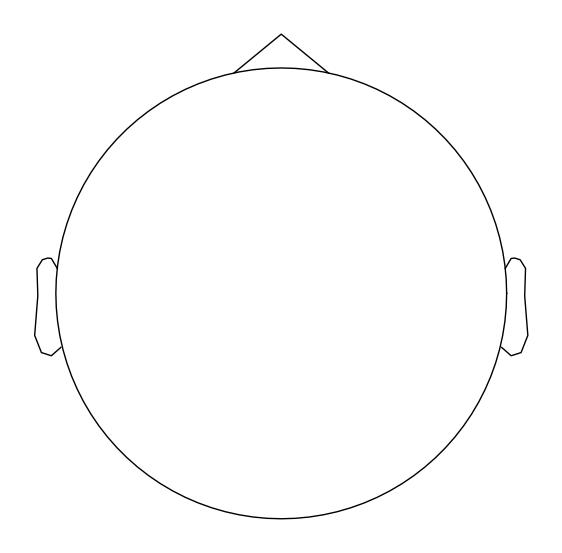

In [ ]:
# Generate head picture for visualisations
mtg_chan = {'FP1': [-0.03, 0.08, 0],
 'FP2': [0.03, 0.08, 0],
 'F7': [-0.073, 0.047, 0],
 'F3': [-0.04, 0.041, 0],
 'Fz': [0, 0.038, 0],
 'F4': [0.04, 0.041, 0],
 'F8': [0.073, 0.047, 0],
 'T3': [-0.085, 0, 0],
 'C3': [-0.045, 0, 0],
 'Cz': [0, 0, 0],
 'C4': [0.045, 0, 0],
 'T4': [0.085, 0, 0],
 'T5': [-0.073, -0.047, 0],
 'P3': [-0.04, -0.041, 0],
 'Pz': [0, -0.038, 0],
 'P4': [0.04, -0.041, 0],
 'T6': [0.07, -0.047, 0],
 'O1': [-0.03, -0.08, 0],
 'O2': [0.03, -0.08, 0]}
import mne
info = mne.create_info(list(mtg_chan.keys()), 500, ch_types='eeg')
montage = mne.channels.make_dig_montage(mtg_chan)
info.set_montage(montage)
fig, ax = plt.subplots(figsize=(7,7))
mne.viz.plot_sensors(info, ch_type='eeg', pointsize=0, axes=ax)
fig.savefig('head.png', bbox_inches='tight', transparent=True)
plt.style.use('default')

In [ ]:
def barchart(table, x, heights, color=None, ax=None, palette=None, orient='h', xlab=None, ylab=None):
    if ax is None:
        fig, ax = plt.subplots()
    if orient == 'v':
        barfunc = ax.bar
        ax.yaxis.grid(True)
        ax.xaxis.grid(False)
        ax.set_xlabel(x)
        ax.set_ylabel(heights)
    else:
        barfunc = ax.barh
        ax.xaxis.grid(True)
        ax.yaxis.grid(False)
        ax.invert_yaxis()
        ax.set_ylabel(x)
        ax.set_xlabel(heights)
    if xlab is not None:
        ax.set_xlabel(xlab)
    if ylab is not None:
        ax.set_ylabel(ylab)
    if color is not None:
        colors = [palette[cat] for cat in table.feature_cat]
        patches = [mpatches.Patch(color=c, label=ftr_cat) for ftr_cat, c in palette.items()]
        ax.legend(patches, palette.keys())
    else:
        colors = None
    barfunc(table[x], table[heights], color=colors)
    return ax

# Ensure consistent coloration
feature_category = [
    'delta PSD',
    'delta FC',
    'theta PSD',
    'theta FC',
    'alpha PSD',
    'alpha FC',
    'beta PSD',
    'beta FC',
    'highbeta PSD',
    'highbeta FC',
    'gamma PSD',
    'gamma FC']
cmap = plt.get_cmap('tab20')
palette = {feature_category[i]: cmap.colors[i] for i in range(len(feature_category))}

# position of channels on EEG map
chs = {
    'FP1': [-0.2625, 0.6300000000000001],
    'FP2': [0.2625, 0.6300000000000001],
    'F7': [-0.6387499999999999, 0.34125],
    'F3': [-0.35000000000000003, 0.28875],
    'Fz': [0.0, 0.2625],
    'F4': [0.35000000000000003, 0.28875],
    'F8': [0.6387499999999999, 0.34125],
    'T3': [-0.74375, -0.07],
    'C3': [-0.39375, -0.07],
    'Cz': [0.0, -0.07],
    'C4': [0.39375, -0.07],
    'T4': [0.74375, -0.07],
    'T5': [-0.6387499999999999, -0.48125],
    'P3': [-0.35000000000000003, -0.42875],
    'Pz': [0.0, -0.4025],
    'P4': [0.35000000000000003, -0.42875],
    'T6': [0.6125, -0.48125],
    'O1': [-0.2625, -0.77],
    'O2': [0.2625, -0.77]}
channels = pd.DataFrame(chs).transpose()

sns.set_style('whitegrid')

def extract_channel(feature):
    """
    Extract channels from QEEG feature names
    Examples:
    delta.T4 -> T4
    COH.delta.Cz.T4 -> [Cz, T4]
    """
    split = feature.split(sep='.')
    if split[0] == 'COH':
        result = split[2:4]
    else:
        result = split[-1]
    return result

def get_channels(features):
    """
    Get channels from comma separated feature names.
    Examples:
    delta.T4, COH.delta.Cz.T4 -> [T4, [Cz, T4]]
    """
    split = features.split(sep=',')
    result = [extract_channel(ftr) for ftr in split]
    return np.array(result)

def get_coordinates(channels_arr):
    """Extract x and y coordinates by channel names"""
    selected = channels.loc[channels_arr]
    x, y = selected.iloc[:, 0], selected.iloc[:, 1]
    return x,y

def fi_viz(table, feature, feature_cat, importance, palette, figure=None, cat=True):
    if figure is None:
        figure = plt.figure()
    if cat:
        axes = figure.subplots(1, 2)
        cat_fi = table.groupby(feature_cat)[importance].sum().reset_index().sort_values(importance, ascending=False)
        barchart(cat_fi, feature_cat, importance, feature_cat, axes[1], palette, xlab='importance', ylab='feature category')
    else:
        axes = figure.subplots()
        axes = [axes]
    barchart(table, feature, importance, feature_cat, axes[0], palette, xlab='importance')
    return figure

def fi_viz_eeg(table,  palette, feature='feature', feature_cat='feature_cat', figure=None, ax=None, separate=True, img_path='head.png'):
    # Read backgroud image
    im = plt.imread('head.png')
    if ax is not None:
        separate=False
    elif figure is None:
        figure = plt.figure()
    if separate:
        axes = figure.subplots(1, 2)
        ax_psd = axes[0]
        ax_coh = axes[1]
        axes[0].set_title('Power Spectral Density (PSD)')
        axes[1].set_title('Functional Connectivity (FC)')
    else:
        if ax is None:
            axes = figure.subplots()
        else:
            axes = ax
        ax_psd = axes
        ax_coh = axes
        axes = [axes]
    # Plot
    ftrcat_channels  = table.groupby(feature_cat)[feature].agg(','.join).transform(get_channels)
    for ftr_cat, channels_arr in ftrcat_channels.items():
        color = palette[ftr_cat]
        if 'PSD' in ftr_cat:
            x, y = get_coordinates(channels_arr)
            ax_psd.scatter(x, y, c=[color], s=plt.rcParams['lines.markersize'] ** 3.5, label=ftr_cat)
        else:
            for i, arr in enumerate(channels_arr):
                x, y = get_coordinates(arr)
                if i == 0:
                    lab = ftr_cat
                else:
                    lab = None
                ax_coh.plot(x, y, c=color, linewidth=12, label=lab)

    for txt in channels.index:
        for ax in axes:
            text = ax.text(channels.loc[txt, 0], channels.loc[txt, 1], txt, color='white', fontweight='extra bold',
                           horizontalalignment='center', verticalalignment='center')
            text.set_path_effects([PathEffects.withStroke(linewidth=3, foreground='black')])

    for ax in axes:
        ax.imshow(im, extent=[-1, 1, -1, 1])
        ax.axis('off')
        ax.margins(x=0, y=0)
        box = ax.get_position()
        ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
        # Put a legend to the right of the current axis
        ax.legend(loc='center left', bbox_to_anchor=(1, 0.5), labelspacing=1.5, frameon=False)


def report_fi(res_tab, disorder, col='importance_sum', survival_thres=0.7, palette=palette, root_dir=None):
    # extract top n features
    table = top_n(flatten_columns(summary_fi_table(res_tab)), survival_thres=survival_thres).reset_index()
    # recreate palette to include only relevant colors
    unq_cat = table['feature_cat'].unique()
    palette = {key: item for key, item in palette.items() if key in unq_cat}
    # Barchart feature and category importance
    fig1 = plt.figure(tight_layout=True, figsize=(15, 5))
    fig1.suptitle(disorder)
    fi_viz(table, 'feature', 'feature_cat', col, palette, fig1)
    fig1.tight_layout()
    # Plot feature importance on EEG map
    fig2 = plt.figure(tight_layout=True, figsize=(15, 7))
    fi_viz_eeg(table, figure=fig2, palette=palette)
    fig2.tight_layout()
    # root directory for saving plots to files
    if root_dir is not None:
        save_dir = cache_mkdir(True, disorder.replace(' ', '_'), root_dir)
        img_path = os.path.join(save_dir, 'fi1.png')
        fig1.savefig(img_path, bbox_inches='tight')
        img_path = os.path.join(save_dir, 'fi2.png')
        fig2.savefig(img_path, bbox_inches='tight')

In [ ]:
!rm -rf viz

In [ ]:
md_cv = do_cv_fi(md, md_results, Xmd, Ymd, random_state=77)

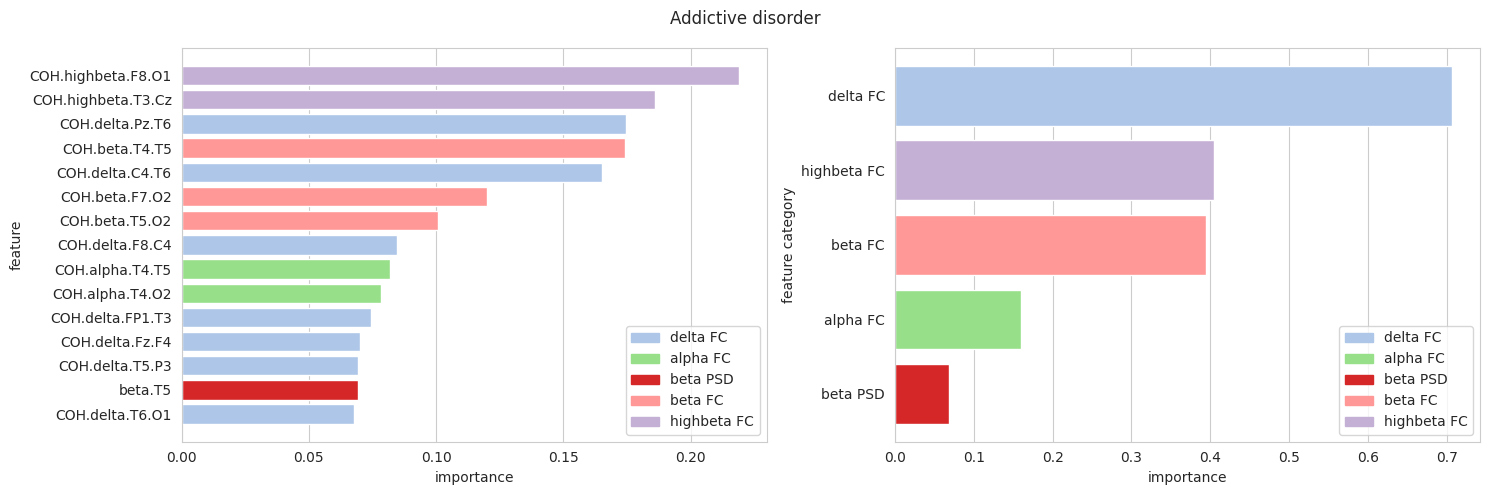

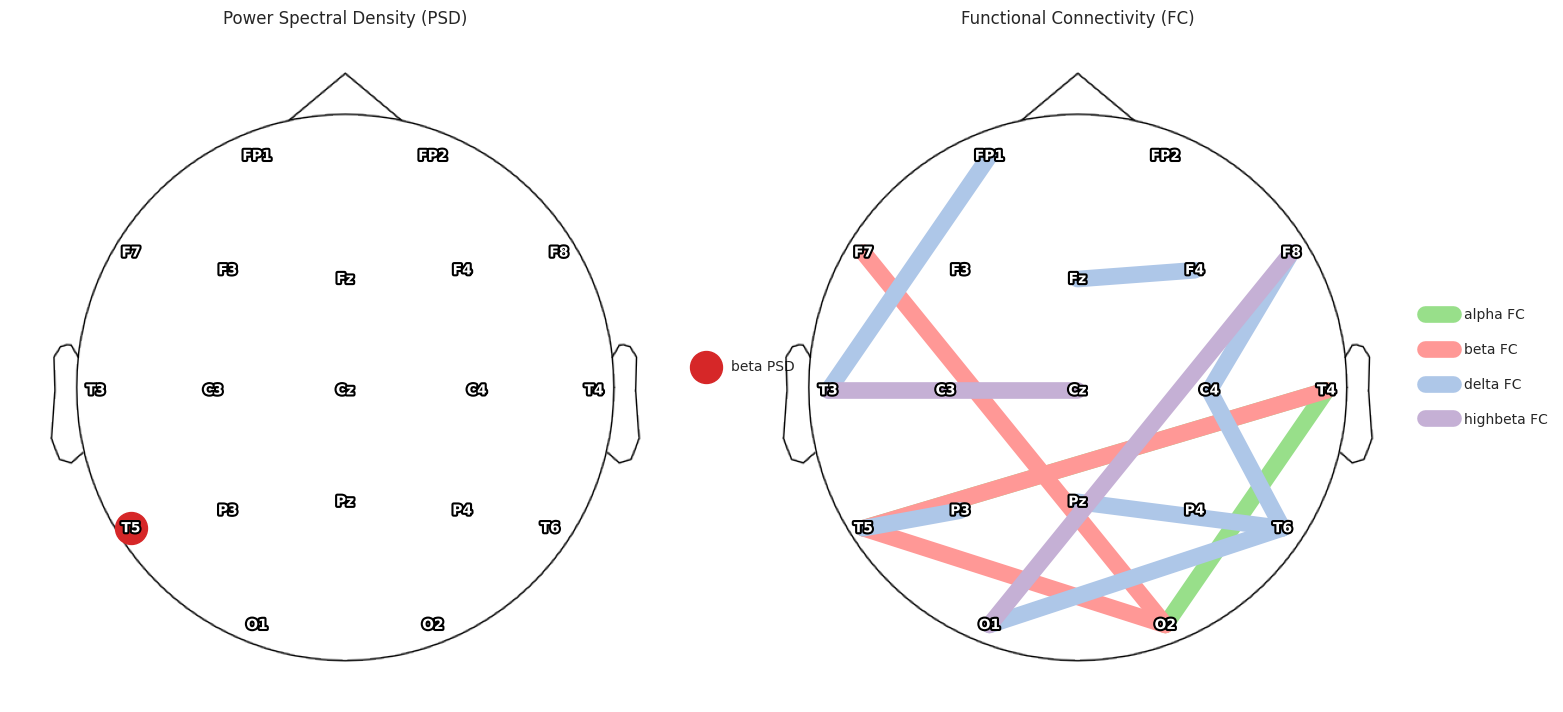

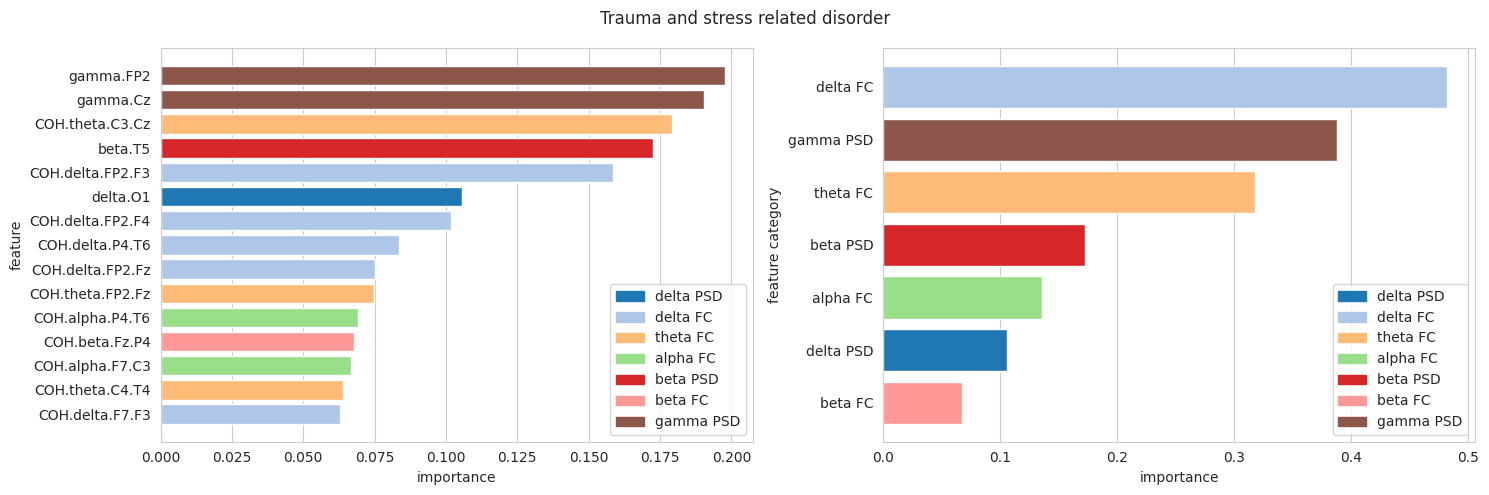

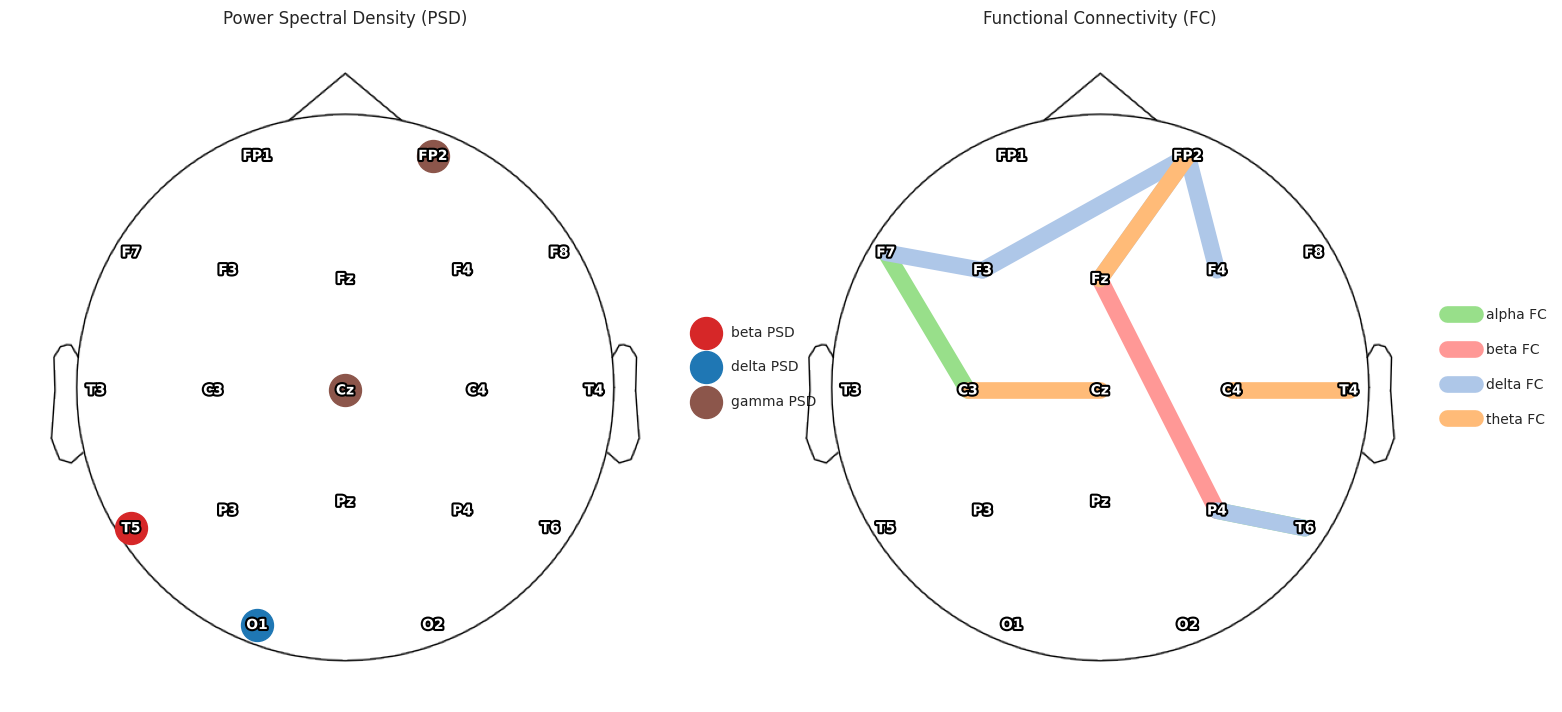

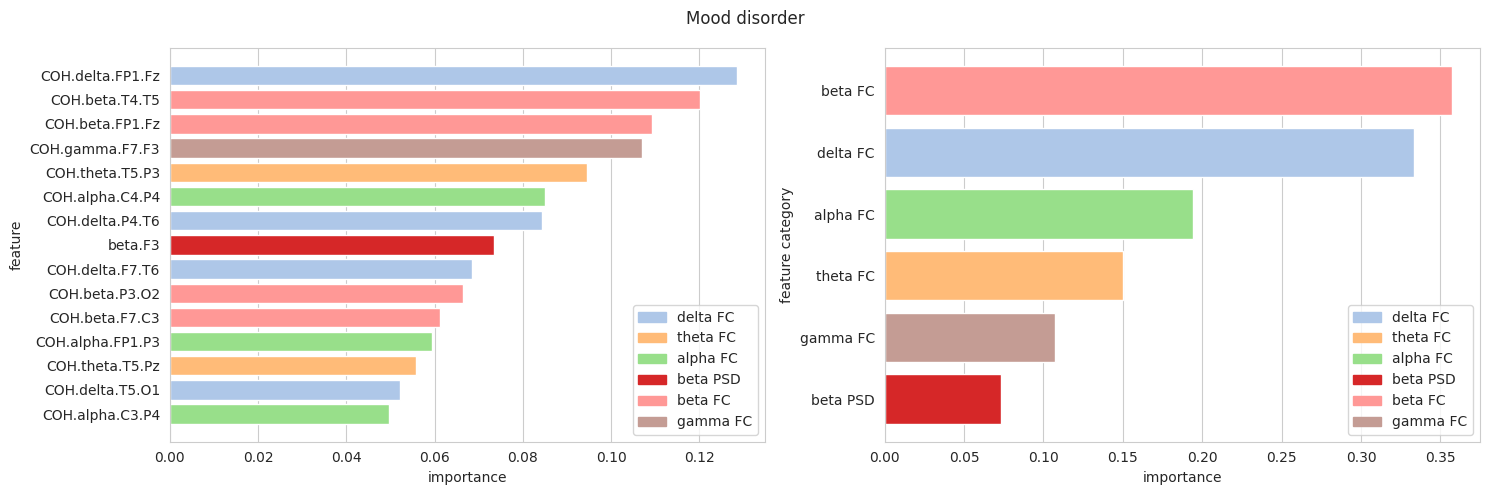

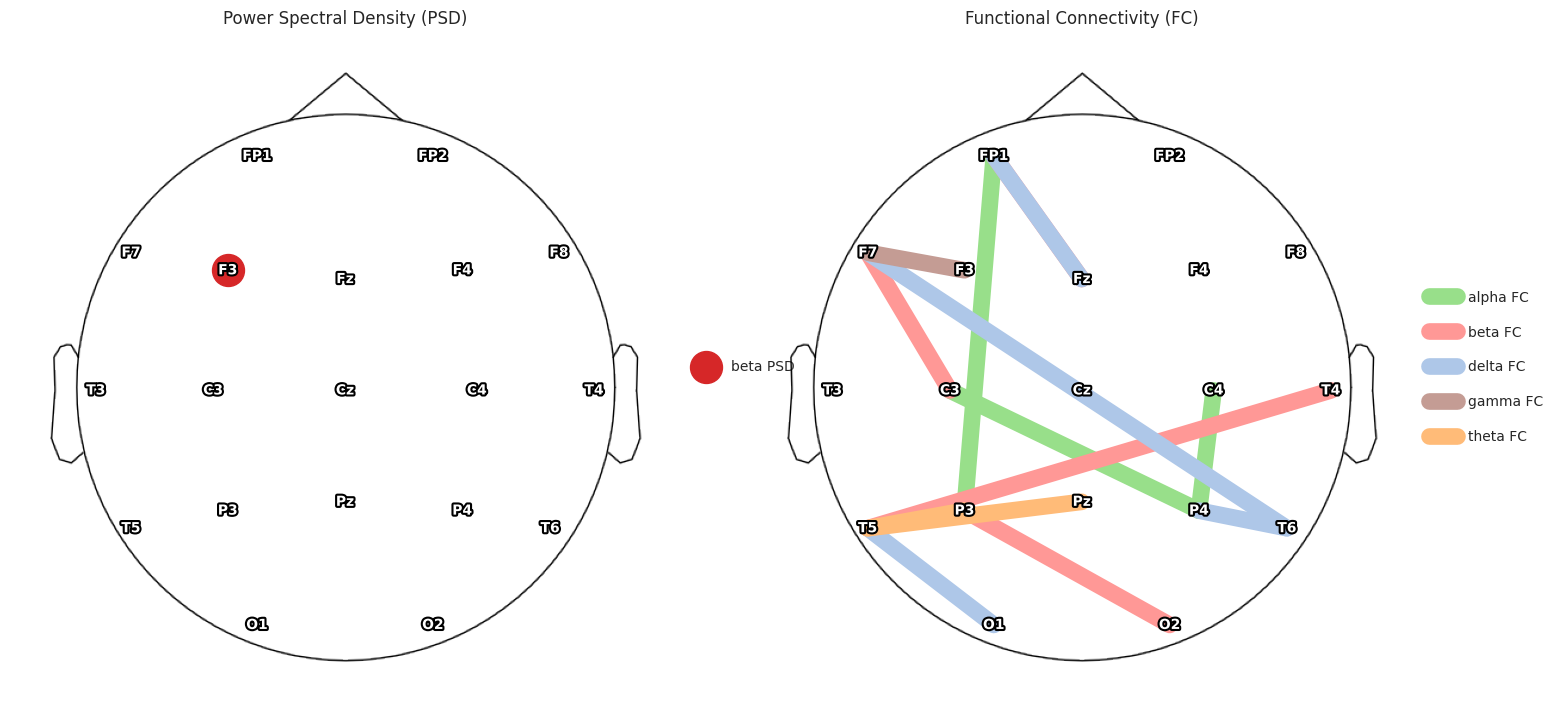

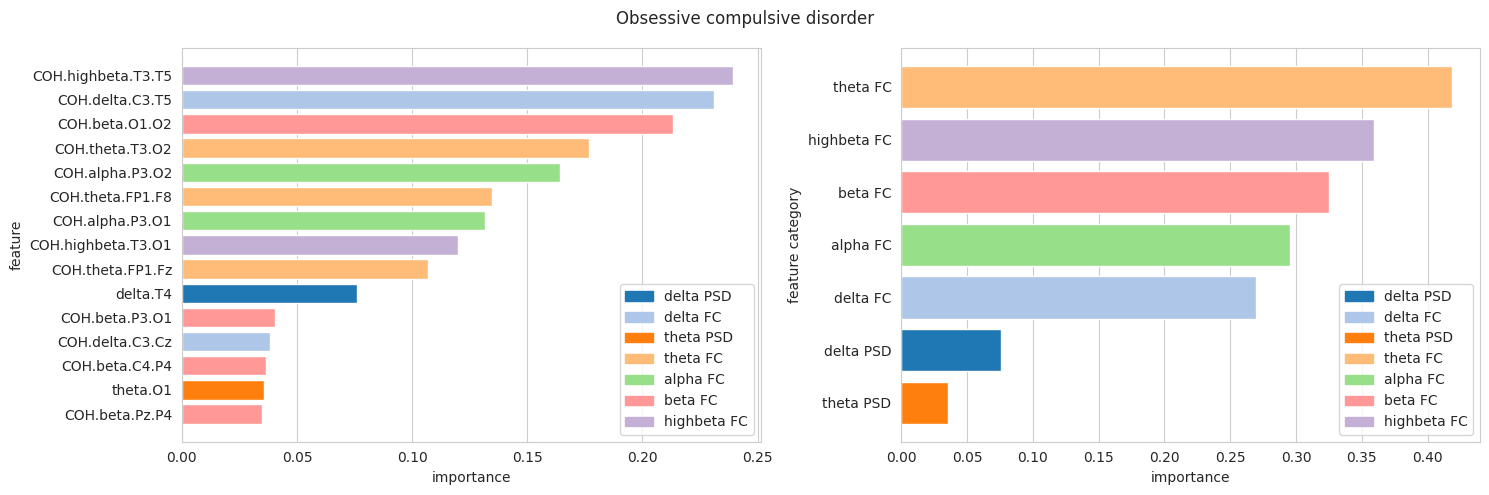

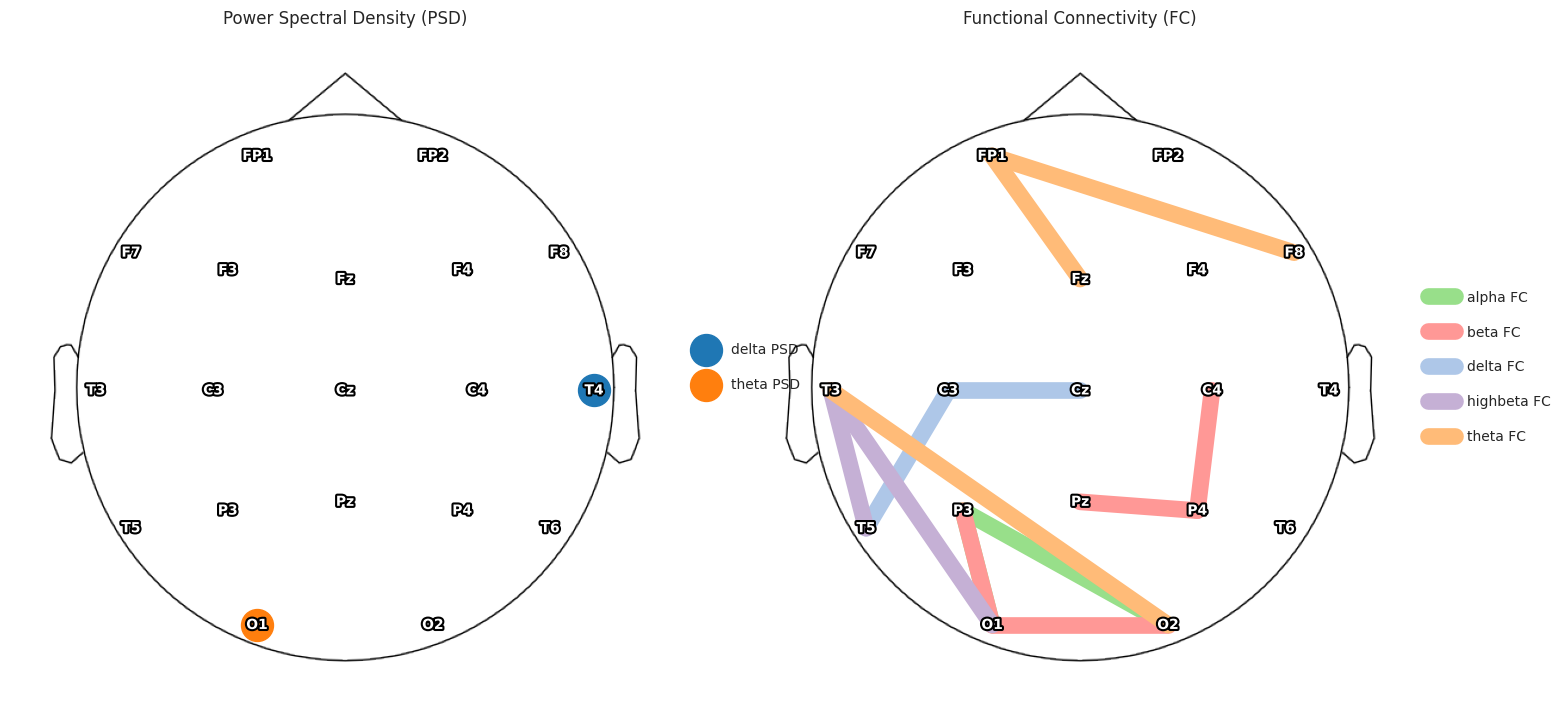

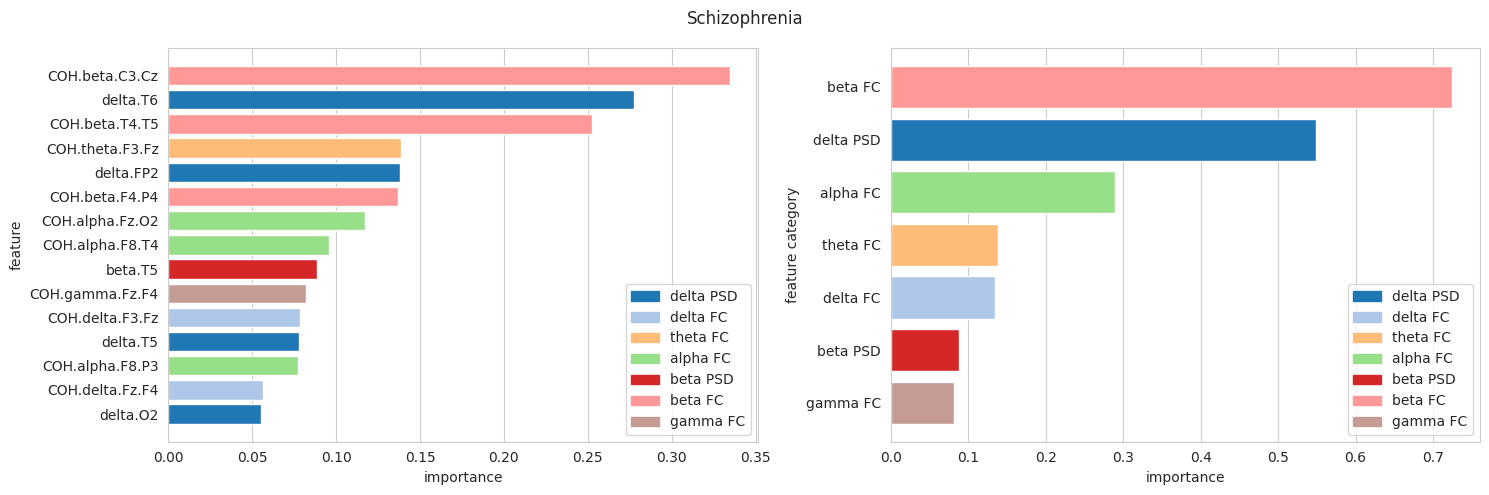

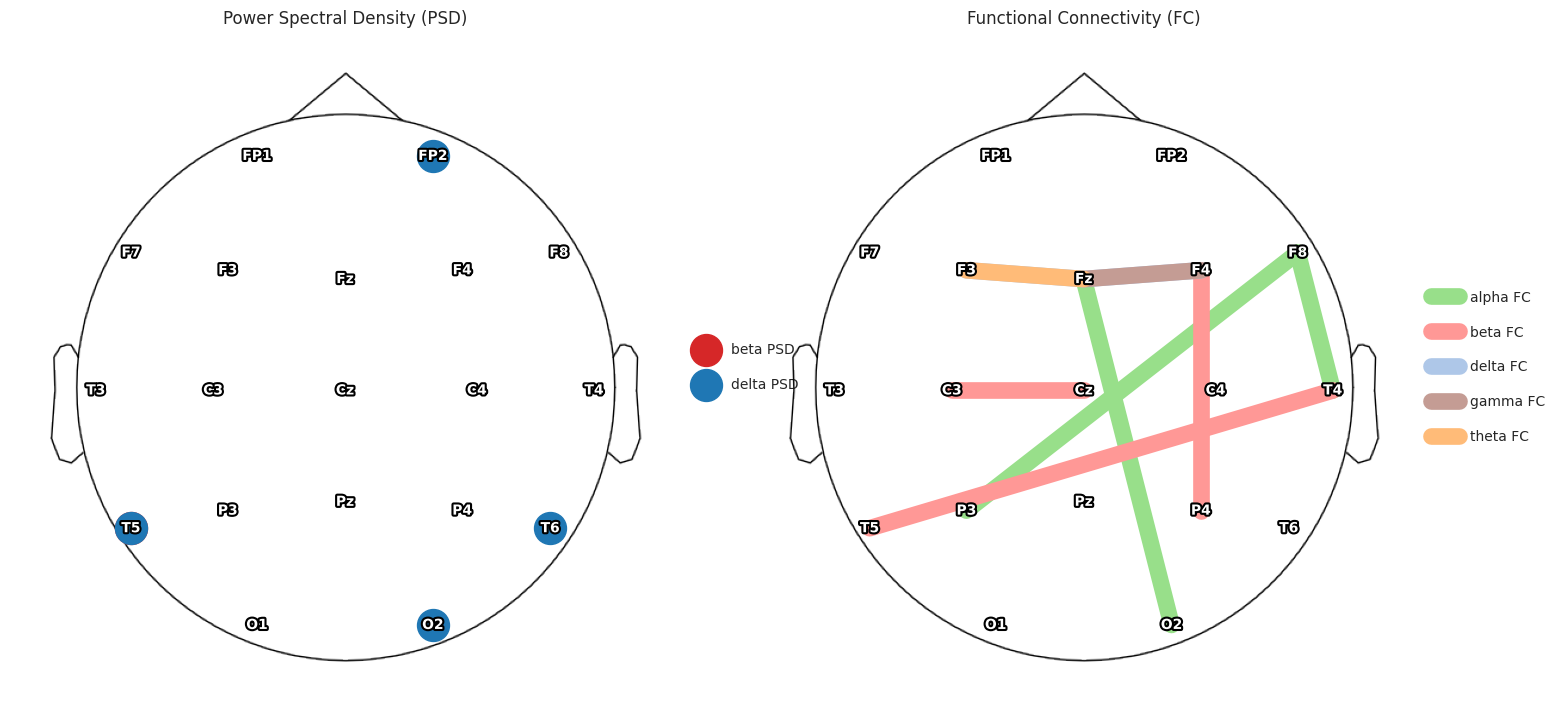

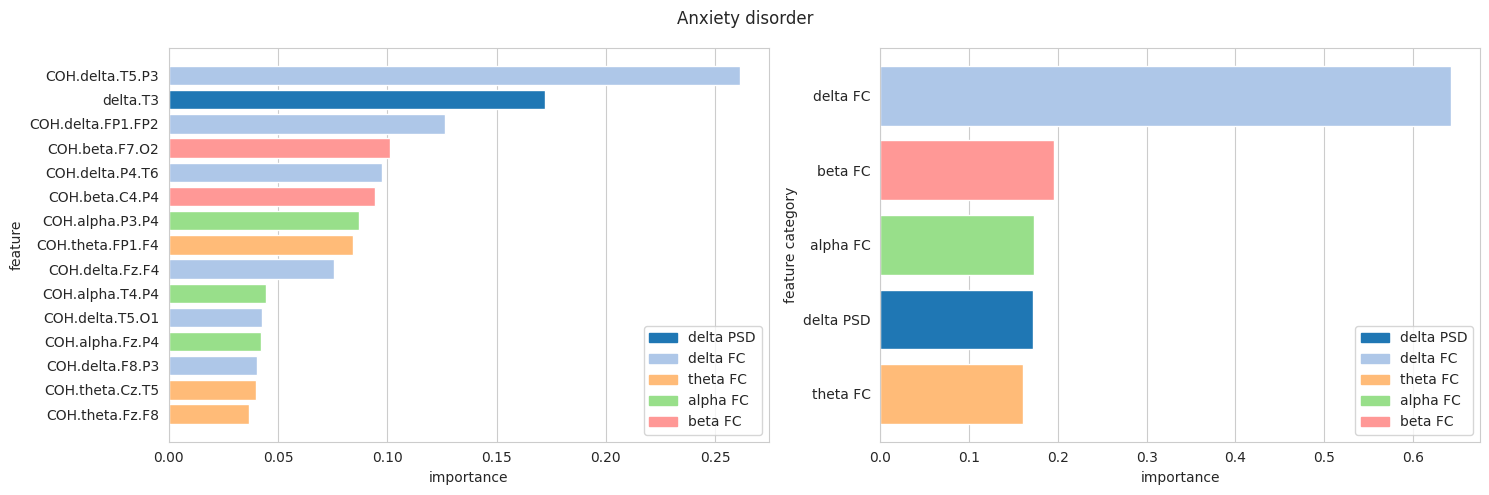

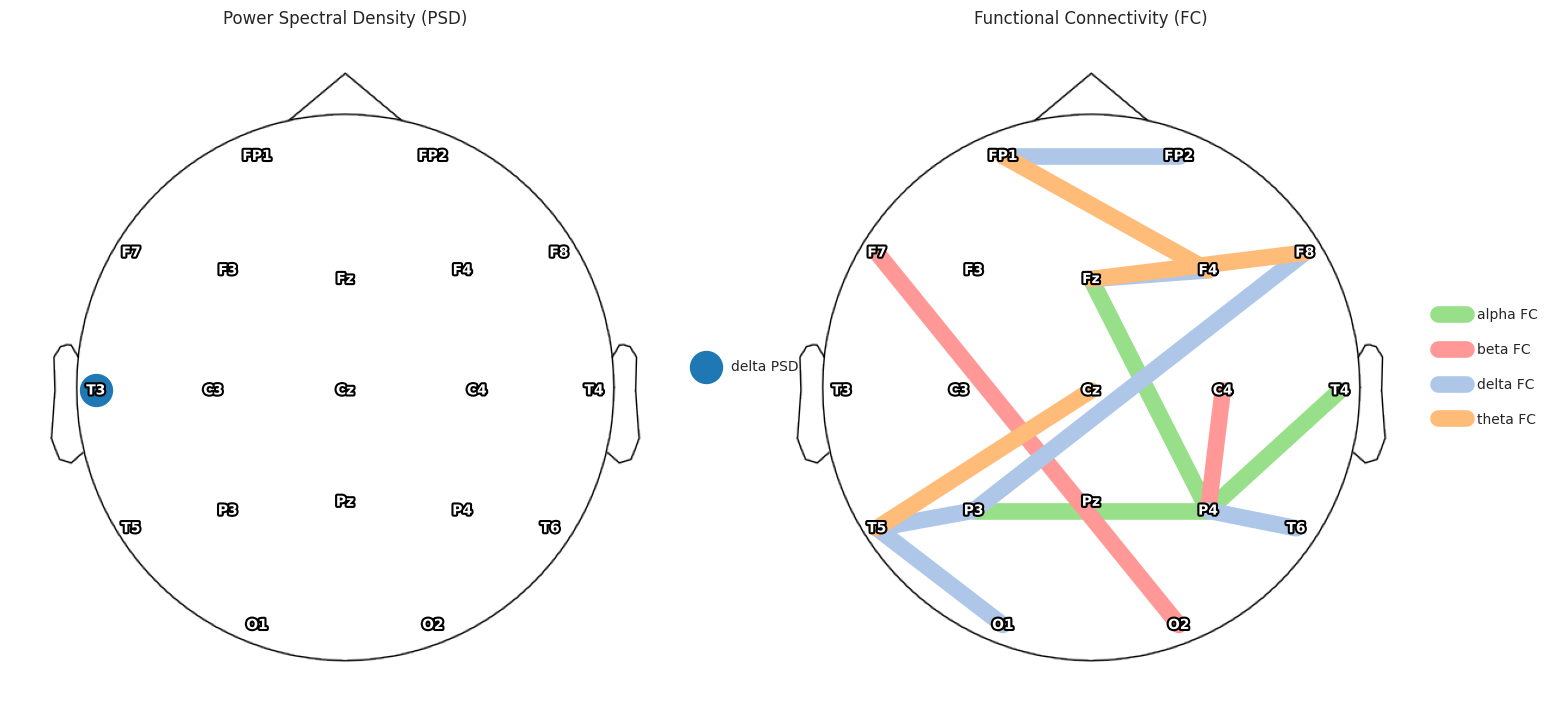

In [ ]:
for key, item in md_cv.items():
    fig = report_fi(item, key, 'abs_col', root_dir='viz')
    plt.show()

In [ ]:
# sd_cv = do_cv_fi(sd, sd_results, Xsd, Ysd, random_state=77)

NameError: name 'sd_results' is not defined

In [ ]:
for key, item in sd_cv.items():
    fig = report_fi(item, key, 'abs_col', root_dir='viz')
    plt.show()

In [ ]:
def plot_eeg_fi(res_tab, disorder, ax=None, palette=palette):
    table = top_n(flatten_columns(summary_fi_table(res_tab))).reset_index()
    im = plt.imread('head.png')
    if ax is None:
        fig, ax = plt.subplots(figsize=(7, 7))
    # recreate palette to include only relevant colors
    unq_cat = table['feature_cat'].unique()
    palette = {key: item for key, item in palette.items() if key in unq_cat}
    # visualize
    fi_viz_eeg(table, ax=ax, separate=False, palette=palette)
    ax.set_title(disorder)

In [ ]:
all_disorders = deepcopy(md_cv)
all_disorders.update(sd_cv)
fig, axes = plt.subplots(3, 5, figsize=(7*5, 7*3))
for disorder, ax in zip(all_disorders.keys(), axes.flatten()):
    plot_eeg_fi(all_disorders[disorder], disorder, ax)
fig.savefig('disorders_fi.png', bbox_inches='tight')
plt.show()

NameError: name 'sd_cv' is not defined

In [ ]:
!cp -r grid_search_model /content/drive/MyDrive/AccioBeer